In [192]:
import h5py
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

import pyrenn
from numpy import linalg as LA
import random
from sklearn.metrics import r2_score as r2
from scipy.optimize import minimize

import os

In [193]:
def gauss(x, x0, xw):
    return np.exp(-(x-x0)**2/2/(xw/2.35)**2)

def center_of_mass(Ly):
    Lx=range(len(Ly))
    return sum([Lx[i]*Ly[i]for i in range(len(Ly))])/sum(Ly)

def fit_gauss(Ly):
#   center of mass as index
    center=int(center_of_mass(Ly))
    
    def opti(c):
        diff=0
        for x in range(len(Ly)):
            # c[2] = scaling
            # c[1] = mu
            # c[0] = std
            diff+=(c[2]*gauss(x,c[0],c[1])-Ly[x])**2
        return diff

    x0 =[center,1,Ly[center]]
    
#     limits search area in minimization
    
    bnds=[[center-4,center+2],[0.1,20],[Ly[center]*0.5,Ly[center]*2]]
#     including bounds with bounds=bnds might be faster, but requires some tuning
    res = minimize(opti, x0,  bounds=bnds, tol=1e-9)
        
    result=res.x
    
    return result

In [194]:
 xtcav=True
class XfelDataset(Dataset):
    def __init__(self):
        # Read the file with key
        self.data=pd.read_hdf('/mnt/warshadcheema/xfel_data.h5', key='df', mode='r',header=1).astype(float)
        #udamge=np.asarray(self.data.loc[:,'uDamageMask'])==15360
        #ind = [i for i, val in enumerate(udamge) if val]
        #self.data=self.data.drop(ind,axis=0)
        
        
        if xtcav==True:
            ##add data after 52 features or before outputs 
            self.xtcav_img=pd.read_hdf('xfel_data.h5', key='xtcav', mode='r',header=1)
            index=list(self.data.columns).index('intensity_photon_energy_0')
            for each in self.xtcav_img.columns:
                self.data.insert(index, each,self.xtcav_img.loc[:,each])
                index=index+1
                
    ##drop data with no information
        if xtcav==True:
            self.data=self.data.drop(["experiment_id","uDamageMask","ids","exist",'AMO:LMP:VG:20:PRESS', 'AMO:LMP:VG:41:PRESS', 
                                      'AMO:LMP:VG:43:PRESS'],axis=1)
        else:
            self.data=self.data.drop(["experiment_id","uDamageMask", 'AMO:LMP:VG:20:PRESS', 'AMO:LMP:VG:41:PRESS', 
                                      'AMO:LMP:VG:43:PRESS',],axis=1)
        self.features_cols=[]
        for each in self.data.columns:
            if each=='intensity_photon_energy_0':
                break
            self.features_cols.append(each)
        self.features=(self.data.loc[:,self.features_cols])
        self.labels_cols=[]
        for i in range(230):
            temp="intensity_photon_energy_%d" %i
            self.labels_cols.append(temp)
        #read the file with key0new which conatin centre of mass argmax etc.
        self.labels=pd.read_hdf('Hannan_data.h5', key='new', mode='r',header=1).astype(float)
        #self.labels=self.labels.drop(ind,axis=0)
            

    def __getitem__(self, index):
        # Get attributes
        get_attribute = torch.tensor(self.features.iloc[index,:].values.astype(np.float32),dtype=torch.float32)
        #get Labels
        get_label = torch.tensor(self.labels.iloc[index,:].values.astype(np.float32),dtype=torch.float32)
        return get_attribute, get_label

    def __len__(self):
        return len(self.data)
    def __featureslen__(self):
        return len(self.features_cols)
    
         

In [195]:
class GenHelper(Dataset):
    def __init__(self, mother, length, mapping):
        # here is a mapping from this index to the mother dataset index
        self.mapping=mapping
        self.length=length
        self.mother=mother

    def __getitem__(self, index):
        return self.mother[self.mapping[index]]

    def __len__(self):
        return self.length


def train_test_split(dataset, split_fold=10, random_seed=None):
    '''
    This is a pytorch generic function that takes a data.Dataset object and splits it to training and testing
    efficiently.
    :return:
    '''
    if random_seed == None:    
        np.random.seed(random_seed)

    dataset_length=dataset.__len__()
    indices=list(range(dataset_length))
    test_size=dataset_length//split_fold
    validation_size=int(test_size//1.25)
    np.random.shuffle(indices)
    train_mapping=indices[(validation_size+test_size):]
    test_mapping=indices[:test_size]
    validation_mapping=indices[test_size:test_size+validation_size]
    train_set=GenHelper(dataset, dataset_length - test_size-validation_size, train_mapping)
    test_set=GenHelper(dataset, test_size, test_mapping)
    #for tuning hyper parametres
    validation_set=GenHelper(dataset, validation_size, validation_mapping) 

    return train_set, test_set,validation_set

In [196]:
#Creation of datset
data=XfelDataset()                                       
print("Total length of dataset is",data.__len__())
#Splitting into Train,test,validation
train_set,test_set,valid_set=train_test_split(data,5)    
print("Length for Train set",len(train_set))
print("Length for test set",len(test_set))
print("Length for validation set",len(valid_set))
print(len(train_set)+len(test_set)+len(valid_set))

Total length of dataset is 60656
Length for Train set 38821
Length for test set 12131
Length for validation set 9704
60656


In [197]:
class Xfel(nn.Module):
    def __init__(self):
        if xtcav==False:           
            super(Xfel, self).__init__()
            self.fc1 = nn.Linear(data.__featureslen__(), 40)
            self.fc2=nn.Linear(40, 30)
            self.fc3 = nn.Linear(30, 20)
            self.fc4=nn.Linear(20, 13)
            self.fc5=nn.Linear(13,8)
        else:
            super(Xfel, self).__init__()
            self.fc1 = nn.Linear(data.__featureslen__(),1600)
            self.fc2 = nn.Linear(1600, 1100)
            self.fc3 = nn.Linear(1100, 500)
            self.fc4=nn.Linear(500,50)
            self.fc5=nn.Linear(50,8)

    def forward(self, x):
        x = torch.relu(self.fc1(x))     
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x =self.fc5(x)
        return x

In [198]:
num_epochs = 10
learning_rate =0.001
batch_size=10

In [199]:
##load the data into laoders
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size =1, shuffle = False)
valid_loader= torch.utils.data.DataLoader(dataset = valid_set, batch_size =1, shuffle = False)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [205]:
criterion = nn.MSELoss()
net=Xfel().to(device)    
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
scaler=StandardScaler()

In [206]:
def train_nn(net):
    train_loss=0
# create a loss function
    for batch_idx, (inputs, target) in enumerate(train_loader):
        scaler.partial_fit(inputs)  ##use Gaussian scaler to scale the data
        scaler1.partial_fit(target)
        inputs=torch.tensor(scaler.transform(inputs), dtype=torch.float32)
        target=torch.tensor(scaler1.transform(target), dtype=torch.float32)
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        net_out = net.forward(inputs)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_loss=train_loss/len(train_set)*batch_size
    return train_loss

In [207]:
def test_nn(net):
    test_loss=0
    means=[]
    means_original=[]
    random.sample(range(1, len(test_set)), 3)
    k=0
    with torch.no_grad():
        for batch_idx, (inputs, target) in enumerate(test_loader):
            inputs= inputs.to(device)
            net_out = net.forward(inputs).cpu().numpy()
            loss = mse(net_out, target)
            original_label=target.
            predicted=net_out
            means.append(predicted[2])
            means_original.append(original_label[2])
            test_loss+=loss
    test_loss=test_loss/len(test_set)*batch_size
    score=r2(np.asarray(means_original),np.asarray(means))
    return test_loss,score,means,means_original

In [208]:
def valid_nn(net):
    valid_loss=0
    with torch.no_grad():
        for batch_idx, (inputs, target) in enumerate(valid_loader):
            inputs, target = inputs.to(device), target.to(device)
            net_out = net.forward(inputs)
            loss = criterion(net_out, target)
            valid_loss+=loss.item()
    valid_loss=valid_loss/len(valid_set)*batch_size
    return valid_loss    

In [ ]:
#This cell is to determine the learning rate using validation dataset
learning_rates=[0.001,0.1,0.6,4.5,10]
least_error=[]
for learning_rate in learning_rates:
    criterion = nn.MSELoss()
    net=Xfel().to(device)    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scaler=StandardScaler()
    train_loss=[]
    valid_loss=[]
    for i in range(2):
        train_loss.append(train_nn(net))
        valid_loss.append(valid_nn(net))
    least_error.append(min(valid_loss))
learning_rate=learning_rates[least_error.index(min(least_error))]
print(learning_rate)

In [ ]:
#This block is used to compute the batch size using validation set
batch_sizes=[10,50,100,500]
least_error=[]
for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size =1, shuffle = False)
    valid_loader= torch.utils.data.DataLoader(dataset = valid_set, batch_size =1, shuffle = False)
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    net=Xfel().to(device)    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scaler=StandardScaler()
    train_loss=[]
    valid_loss=[]
    for i in range(2):
        train_loss.append(train_nn(net))
        valid_loss.append(valid_nn(net))
    least_error.append(min(valid_loss))
batch_size=batch_sizes[least_error.index(min(least_error))]
print(batch_size)

In [ ]:
#This block is used to train the neural network
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size =1, shuffle = False)
valid_loader= torch.utils.data.DataLoader(dataset = valid_set, batch_size =1, shuffle = False)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
net=Xfel().to(device)    
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
train_loss=[]
for i in range(5):
    scaler=StandardScaler()
    scaler1=StandardScaler()
    train_loss.append(train_nn(net))

In [ ]:
torch.save(net,'Centre_of_mass_xtcav_True')

In [89]:
print(train_loss)

[115.51457849843547, 55.363005339098244, 55.393399480616296, 220.91722735110662, 54.53158813114943]


In [56]:
print(np.asarray(a[2]).mean())

10.557554


In [ ]:
data=pd.read_hdf('xfel_data.h5', key='df', mode='r',header=1).astype(float)
ud=np.asarray(data.loc[:,'uDamageMask'])

In [260]:
a=(ud==15360)
res = [i for i, val in enumerate(a) if val]
print(len(res))

4353


(60656,)


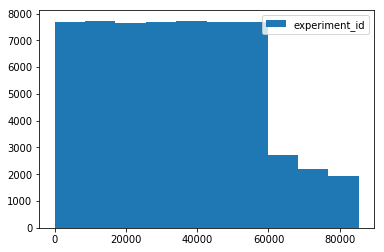

(60656,)


(60656,)


(60656,)


(60656,)


(60656,)


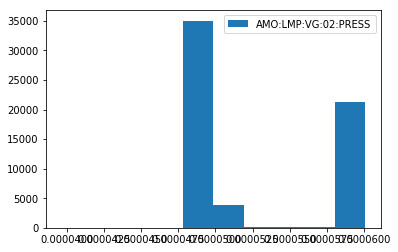

(60656,)


(60656,)


(60656,)


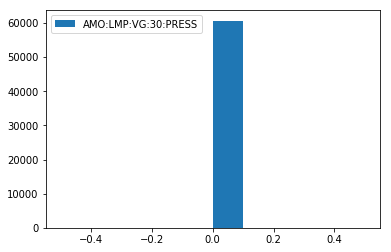

(60656,)


(60656,)


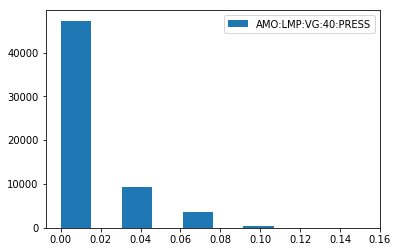

(60656,)


(60656,)


(60656,)


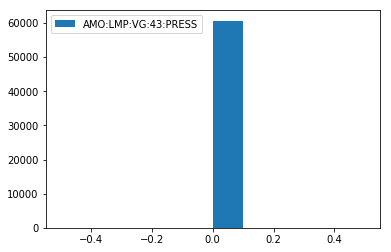

(60656,)


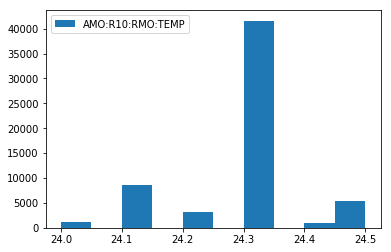

(60656,)


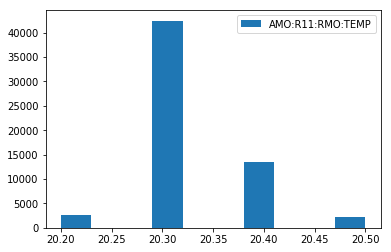

(60656,)


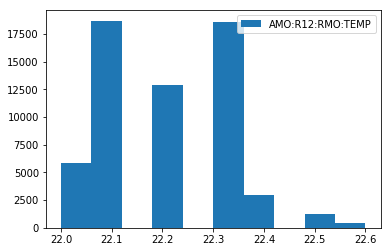

(60656,)


(60656,)


(60656,)


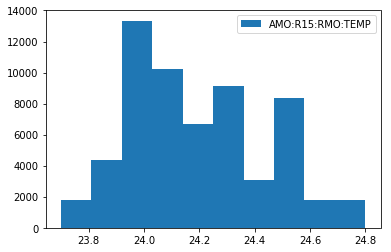

(60656,)


(60656,)


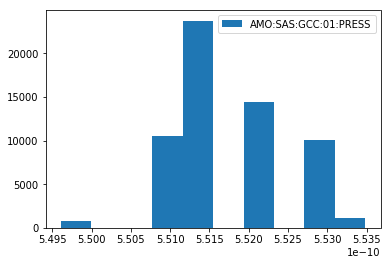

(60656,)


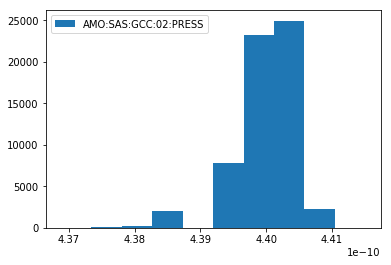

(60656,)


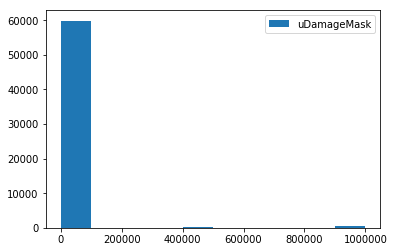

(60656,)


(60656,)


(60656,)


(60656,)


(60656,)


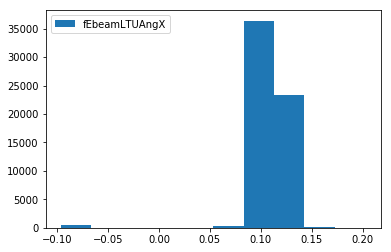

(60656,)


(60656,)


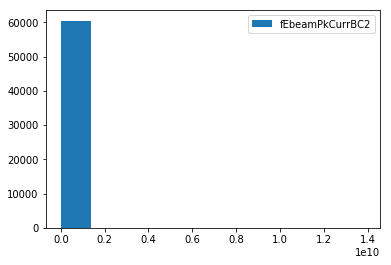

(60656,)


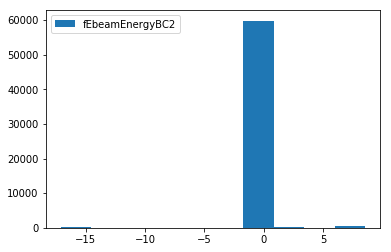

(60656,)


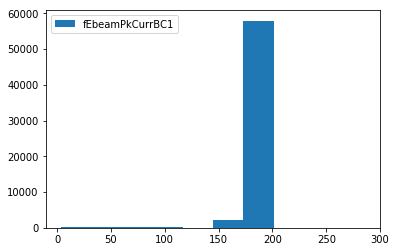

(60656,)


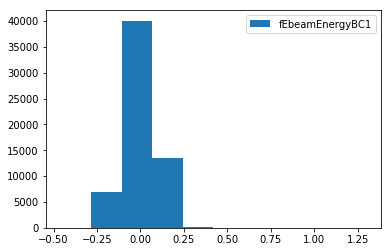

(60656,)


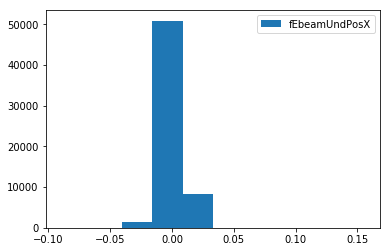

(60656,)


(60656,)


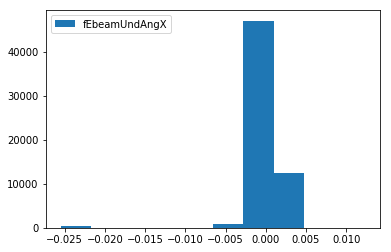

(60656,)


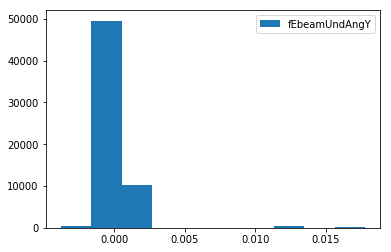

(60656,)


(60656,)


(60656,)


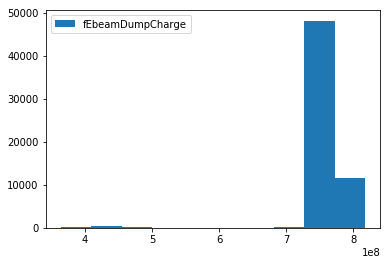

(60656,)


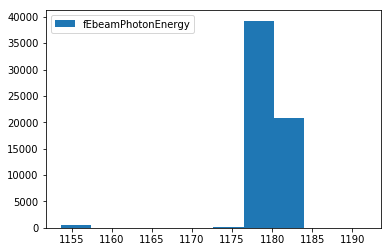

(60656,)


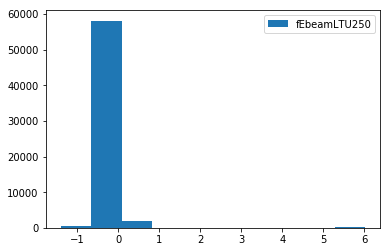

(60656,)


(60656,)


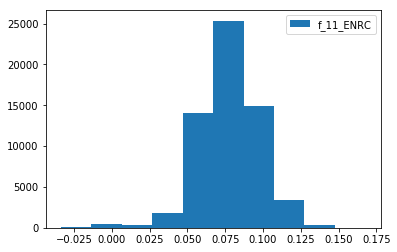

(60656,)


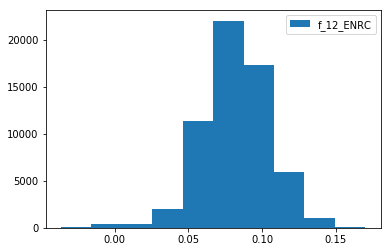

(60656,)


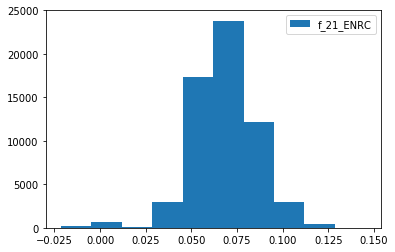

(60656,)


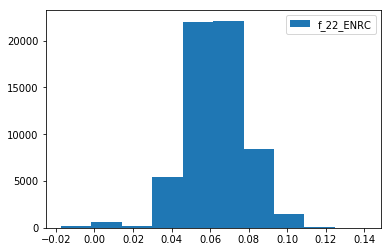

(60656,)


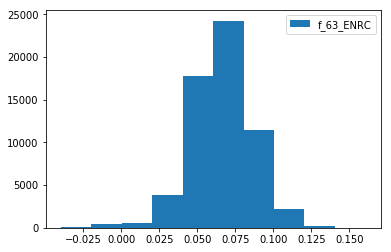

(60656,)


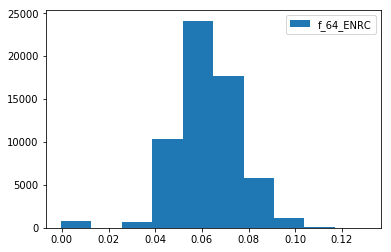

(60656,)


(60656,)


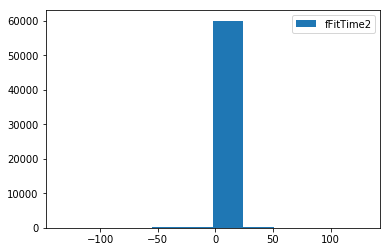

(60656,)


(60656,)


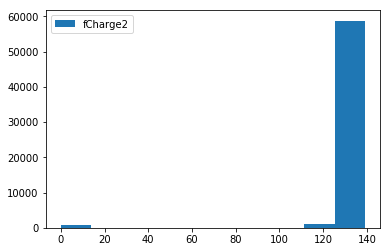

In [254]:
feature_cols=[]
for each in data.columns:
    if each=='intensity_photon_energy_0':
        break
    feature_cols.append(each)
for col in feature_cols:
    a=data.loc[:,col]
    print(a.shape)
    
    plt.hist(a, bins=10, label=col)
    plt.legend()
    plt.show()
    plt.close

In [124]:
print(feature_cols)

['experiment_id', 'AMO:KBO:GCC:01:PRESS', 'AMO:LMP:GCC:10:PRESS', 'AMO:LMP:GCC:11:PRESS', 'AMO:LMP:VG:01:PRESS', 'AMO:LMP:VG:02:PRESS', 'AMO:LMP:VG:20:PRESS', 'AMO:LMP:VG:21:PRESS', 'AMO:LMP:VG:30:PRESS', 'AMO:LMP:VG:31:PRESS', 'AMO:LMP:VG:40:PRESS', 'AMO:LMP:VG:41:PRESS', 'AMO:LMP:VG:42:PRESS', 'AMO:LMP:VG:43:PRESS', 'AMO:R10:RMO:TEMP', 'AMO:R11:RMO:TEMP', 'AMO:R12:RMO:TEMP', 'AMO:R13:RMO:TEMP', 'AMO:R14:RMO:TEMP', 'AMO:R15:RMO:TEMP', 'AMO:R16:RMO:TEMP', 'AMO:SAS:GCC:01:PRESS', 'AMO:SAS:GCC:02:PRESS', 'uDamageMask', 'fEbeamCharge', 'fEbeamL3Energy', 'fEbeamLTUPosX', 'fEbeamLTUPosY', 'fEbeamLTUAngX', 'fEbeamLTUAngY', 'fEbeamPkCurrBC2', 'fEbeamEnergyBC2', 'fEbeamPkCurrBC1', 'fEbeamEnergyBC1', 'fEbeamUndPosX', 'fEbeamUndPosY', 'fEbeamUndAngX', 'fEbeamUndAngY', 'fEbeamXTCAVAmpl', 'fEbeamXTCAVPhase', 'fEbeamDumpCharge', 'fEbeamPhotonEnergy', 'fEbeamLTU250', 'fEbeamLTU450', 'f_11_ENRC', 'f_12_ENRC', 'f_21_ENRC', 'f_22_ENRC', 'f_63_ENRC', 'f_64_ENRC', 'fFitTime1', 'fFitTime2', 'fCharge1', 'f